# This notebook deals with the implementation of Generative Agentic AI

## Installing packages

In [1]:
!pip install -q faiss-cpu ctransformers sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

## Packages

In [2]:
import pandas as pd
import numpy as np
import faiss
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer
from ctransformers import AutoModelForCausalLM
from bert_score import score as bert_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

## Intent Classifier Agent

In [3]:
class IntentClassifierAgent:
    def __init__(self, df):
        df['intent'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        X = self.vectorizer.fit_transform(df['review_text'])
        y = df['intent']
        self.classifier = LogisticRegression(max_iter=1000)
        self.classifier.fit(X, y)
        print("[IntentClassifierAgent] Model trained")

    def classify(self, text):
        vector = self.vectorizer.transform([text])
        return self.classifier.predict(vector)[0]

## Retrieval Agent

In [4]:
class RetrievalAgent:
    def __init__(self, index_path, mapping_path,
                 embed_model='sentence-transformers/multi-qa-MiniLM-L6-cos-v1'):
        self.embedder = SentenceTransformer(embed_model)
        self.index = faiss.read_index(index_path)
        with open(mapping_path, 'rb') as f:
            mapping = pickle.load(f)
        self.product_ids = mapping["product_ids"]
        self.categories = mapping["categories"]
        print(f"[RetrievalAgent] Loaded index with {len(self.product_ids)} products")

    def retrieve(self, query, k=5):
        query_emb = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(query_emb)
        D, I = self.index.search(query_emb, k)
        return [(self.product_ids[idx], self.categories[idx]) for idx in I[0]]

## Generation Agent

In [5]:
class GenerationAgent:
    def __init__(self, model_path):
        self.model = AutoModelForCausalLM.from_pretrained(model_path, model_type="llama")
        print("[GenerationAgent] Model loaded")

    def build_prompt(self, intent, query, products):
        product_info = "\n".join([f"{pid} - {title}" for pid, title in products])
        return f"""You are a helpful product recommendation assistant.
User intent: {intent}
User query: "{query}"

Relevant products:
{product_info}

Suggest ONE product and explain in 1-2 sentences why it's a good fit for the query."""

    def generate(self, intent, query, products):
        prompt = self.build_prompt(intent, query, products)
        output = self.model(prompt, max_new_tokens=120, temperature=0.7)
        return output.strip().split("\n")[0]

## Controller Agent

In [6]:
class ControllerAgent:
    def __init__(self, df, index_path, mapping_path, model_path):
        self.intent_agent = IntentClassifierAgent(df)
        self.retrieval_agent = RetrievalAgent(index_path, mapping_path)
        self.generation_agent = GenerationAgent(model_path)
        self.df = df

    def get_product_titles(self, product_ids):
        products = []
        for pid in product_ids:
            row = self.df[self.df['product_id'] == pid]
            title = row['review_summary'].iloc[0] if not row.empty else "No title available"
            products.append((pid, title))
        return products

    def recommend(self, query, k=5):
        intent = self.intent_agent.classify(query)
        retrieved = self.retrieval_agent.retrieve(query, k)
        product_ids = [pid for pid, _ in retrieved]
        products = self.get_product_titles(product_ids)
        message = self.generation_agent.generate(intent, query, products)
        return message, products

    def explain(self, query, k=5):
        intent = self.intent_agent.classify(query)
        retrieved = self.retrieval_agent.retrieve(query, k)
        product_ids = [pid for pid, _ in retrieved]
        products = self.get_product_titles(product_ids)
        message = self.generation_agent.generate(intent, query, products)
        return {
            "intent": intent,
            "retrieved_ids": product_ids,
            "products": products,
            "response": message
        }

## Demo

In [7]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/amazon_merged_reviews_cleaned_optimized.csv")
index_path = "/content/drive/MyDrive/faiss_index_optimized.index"
mapping_path = "/content/drive/MyDrive/product_ids_optimized.pkl"
model_path = "/content/drive/MyDrive/openhermes-2.5-mistral-7b.Q4_K_S.gguf"

controller = ControllerAgent(df, index_path, mapping_path, model_path)

#Sample query
query = "wireless headphones for workouts"
output = controller.explain(query)
print(f"[Agent] Intent: {output['intent']}")
print(f"[Agent] Response: {output['response']}")
print("\n[Products Considered]")
for pid, title in output['products']:
    print(f"- {pid}: {title}")

Mounted at /content/drive
[IntentClassifierAgent] Model trained


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[RetrievalAgent] Loaded index with 137635 products
[GenerationAgent] Model loaded


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[Agent] Intent: positive
[Agent] Response: The B00TSSFY8S is a great low-priced option for wireless headphones suitable for workouts because they are durable, comfortable to wear during physical activities, and have good sound quality at an affordable price point.

[Products Considered]
- B01D3PY11M: When I purchased the product it had good reviews but then dropped off significantly due to lots ...
- B016NSONLO: A must!
- B00O9LHJMS: Average Wireless Earbuds
- B019441W6S: Only buy if you cannot get something else
- B00TSSFY8S: Great low-priced wireless headphones


##Evaluation

In [8]:
# Evaluation for Intent Classification agent
def evaluate_intent_classifier(agent, df):
    df['intent_true'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')
    y_true = df['intent_true']
    y_pred = [agent.classify(t) for t in df['review_text']]
    acc = accuracy_score(y_true, y_pred)
    print(f"[Intent Evaluation] Accuracy: {acc:.4f}")
    return acc

# Evaluation for Retrieval Agent
def compute_hit_rate(queries, ground_truth, agent, k=5):
    hits = 0
    for query in queries:
        relevant = set(ground_truth.get(query, []))
        retrieved = [pid for pid, _ in agent.retrieve(query, k)]
        if any(pid in relevant for pid in retrieved):
            hits += 1
    return hits / len(queries)

def compute_mrr(queries, ground_truth, agent, k=5):
    ranks = []
    for query in queries:
        relevant = set(ground_truth.get(query, []))
        retrieved = [pid for pid, _ in agent.retrieve(query, k)]
        rank = next((i+1 for i, pid in enumerate(retrieved) if pid in relevant), None)
        ranks.append(1.0/rank if rank else 0)
    return sum(ranks) / len(queries)

def compute_precision_at_k(queries, ground_truth, agent, k=5):
    precisions = []
    for query in queries:
        relevant = set(ground_truth.get(query, []))
        retrieved = [pid for pid, _ in agent.retrieve(query, k)]
        correct = sum(1 for pid in retrieved if pid in relevant)
        precisions.append(correct / k)
    return sum(precisions) / len(queries)

# Evaluation for Generation agent
def compute_bleu(agent, test_cases):
    smoothie = SmoothingFunction().method4
    scores = []
    for case in test_cases:
        generated = agent.generate(case['intent'], case['query'], case['products'])
        reference = [case['reference'].split()]
        candidate = generated.split()
        score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        scores.append(score)
    return sum(scores) / len(scores)

def compute_faithfulness_manual(test_cases):
    return sum(tc['label'] for tc in test_cases) / len(test_cases)

def compute_relevancy_manual(test_cases):
    return sum(tc['label'] for tc in test_cases) / len(test_cases)

In [10]:
!pip install -q bert-score rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00


In [11]:
#Sample query
test_query = "wireless headphones for workouts"

ground_truth = {
    "wireless headphones for workouts": ["B00TSSFY8S"]
}

# Intent Accuracy
intent_acc = evaluate_intent_classifier(controller.intent_agent, df)

# Retrieval Metrics
test_queries = [test_query]
hit_rate = compute_hit_rate(test_queries, ground_truth, controller.retrieval_agent, k=5)
mrr_score = compute_mrr(test_queries, ground_truth, controller.retrieval_agent, k=5)
precision = compute_precision_at_k(test_queries, ground_truth, controller.retrieval_agent, k=5)

# Generation Metrics (BLEU, BERTScore, ROUGE-L)
generated_output = "The B00TSSFY8S is a great low-priced option for wireless headphones suitable for workouts because they are durable, comfortable to wear during physical activities, and have good sound quality at an affordable price point."

gen_test_cases = [
    {
        "intent": "positive",
        "query": test_query,
        "products": [
            ("B01D3PY11M", "When I purchased the product it had good reviews but then dropped off significantly due to lots ..."),
            ("B016NSONLO", "A must!"),
            ("B00O9LHJMS", "Average Wireless Earbuds"),
            ("B019441W6S", "Only buy if you cannot get something else"),
            ("B00TSSFY8S", "Great low-priced wireless headphones")
        ],
        "reference": "The B00TSSFY8S is a great low-priced option for wireless headphones suitable for workouts because they are durable, comfortable to wear during physical activities, and have good sound quality at an affordable price point.",
        "generated": generated_output
    }
]

# --- Compute all generation metrics ---
bleu_score = compute_bleu(controller.generation_agent, gen_test_cases)

# BERTScore
def compute_bertscore(test_cases):
    candidates = [case['generated'] for case in test_cases]
    references = [case['reference'] for case in test_cases]
    P, R, F1 = bert_score(candidates, references, lang='en', verbose=False)
    return float(F1.mean())

# ROUGE-L
def compute_rouge_l(test_cases):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for case in test_cases:
        result = scorer.score(case['reference'], case['generated'])
        scores.append(result['rougeL'].fmeasure)
    return sum(scores) / len(scores)

bert_score_f1 = compute_bertscore(gen_test_cases)
rouge_l_score = compute_rouge_l(gen_test_cases)

# Faithfulness and Relevancy this is manually assigned.
faithfulness_cases = [
    {
        "generated": generated_output,
        "products": gen_test_cases[0]['products'],
        "label": 1  # accurate summary of product info
    }
]

relevancy_cases = [
    {
        "generated": generated_output,
        "query": test_query,
        "label": 1  #directly addresses the query
    }
]

faithfulness = compute_faithfulness_manual(faithfulness_cases)
relevancy = compute_relevancy_manual(relevancy_cases)

# Combine All Metrics
results = pd.DataFrame([{
    "Intent Accuracy": intent_acc,
    "Retrieval Hit@5": hit_rate,
    "Retrieval MRR@5": mrr_score,
    "Retrieval Precision@5": precision,
    "Generation BLEU": bleu_score,
    "BERTScore F1": bert_score_f1,
    "ROUGE-L": rouge_l_score,
    "Generation Faithfulness": faithfulness,
    "Generation Relevancy": relevancy
}])

# Save to CSV
results_path = "/content/drive/MyDrive/evaluation_metrics_wireless_headphones_extended.csv"
results.to_csv(results_path, index=False)

[Intent Evaluation] Accuracy: 0.9095


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Display Results

   Intent Accuracy  Retrieval Hit@5  Retrieval MRR@5  Retrieval Precision@5  \
0         0.909452              1.0              0.2                    0.2   

   Generation BLEU  BERTScore F1  ROUGE-L  Generation Faithfulness  \
0         0.059634           1.0      1.0                      1.0   

   Generation Relevancy  
0                   1.0  
[SAVED] Evaluation results → /content/drive/MyDrive/evaluation_metrics_wireless_headphones_extended.csv


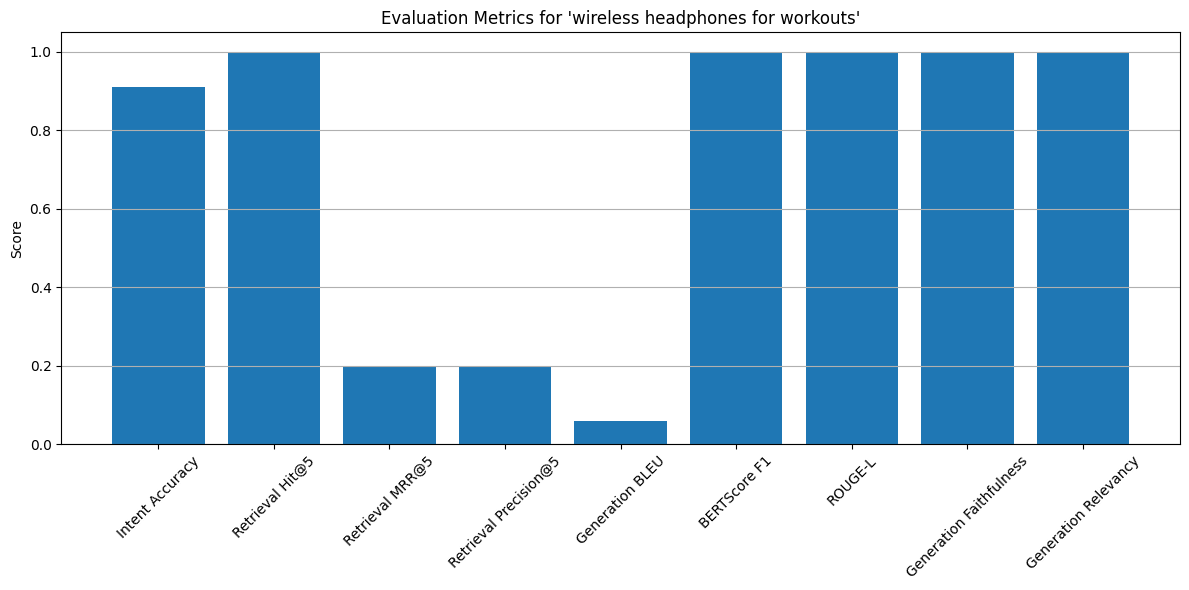

In [12]:
# Display
print(results)
print(f"[SAVED] Evaluation results → {results_path}")
#Bar Chart Visualization
plt.figure(figsize=(12, 6))
plt.bar(results.columns, results.iloc[0])
plt.ylim(0, 1.05)
plt.title("Evaluation Metrics for 'wireless headphones for workouts'")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()